In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # makes the notebook fill the whole window

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.cluster.hierarchy import dendrogram

from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import AgglomerativeClustering

In [3]:
heart = pd.read_excel("./Heart-disease.xlsx")

heart

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


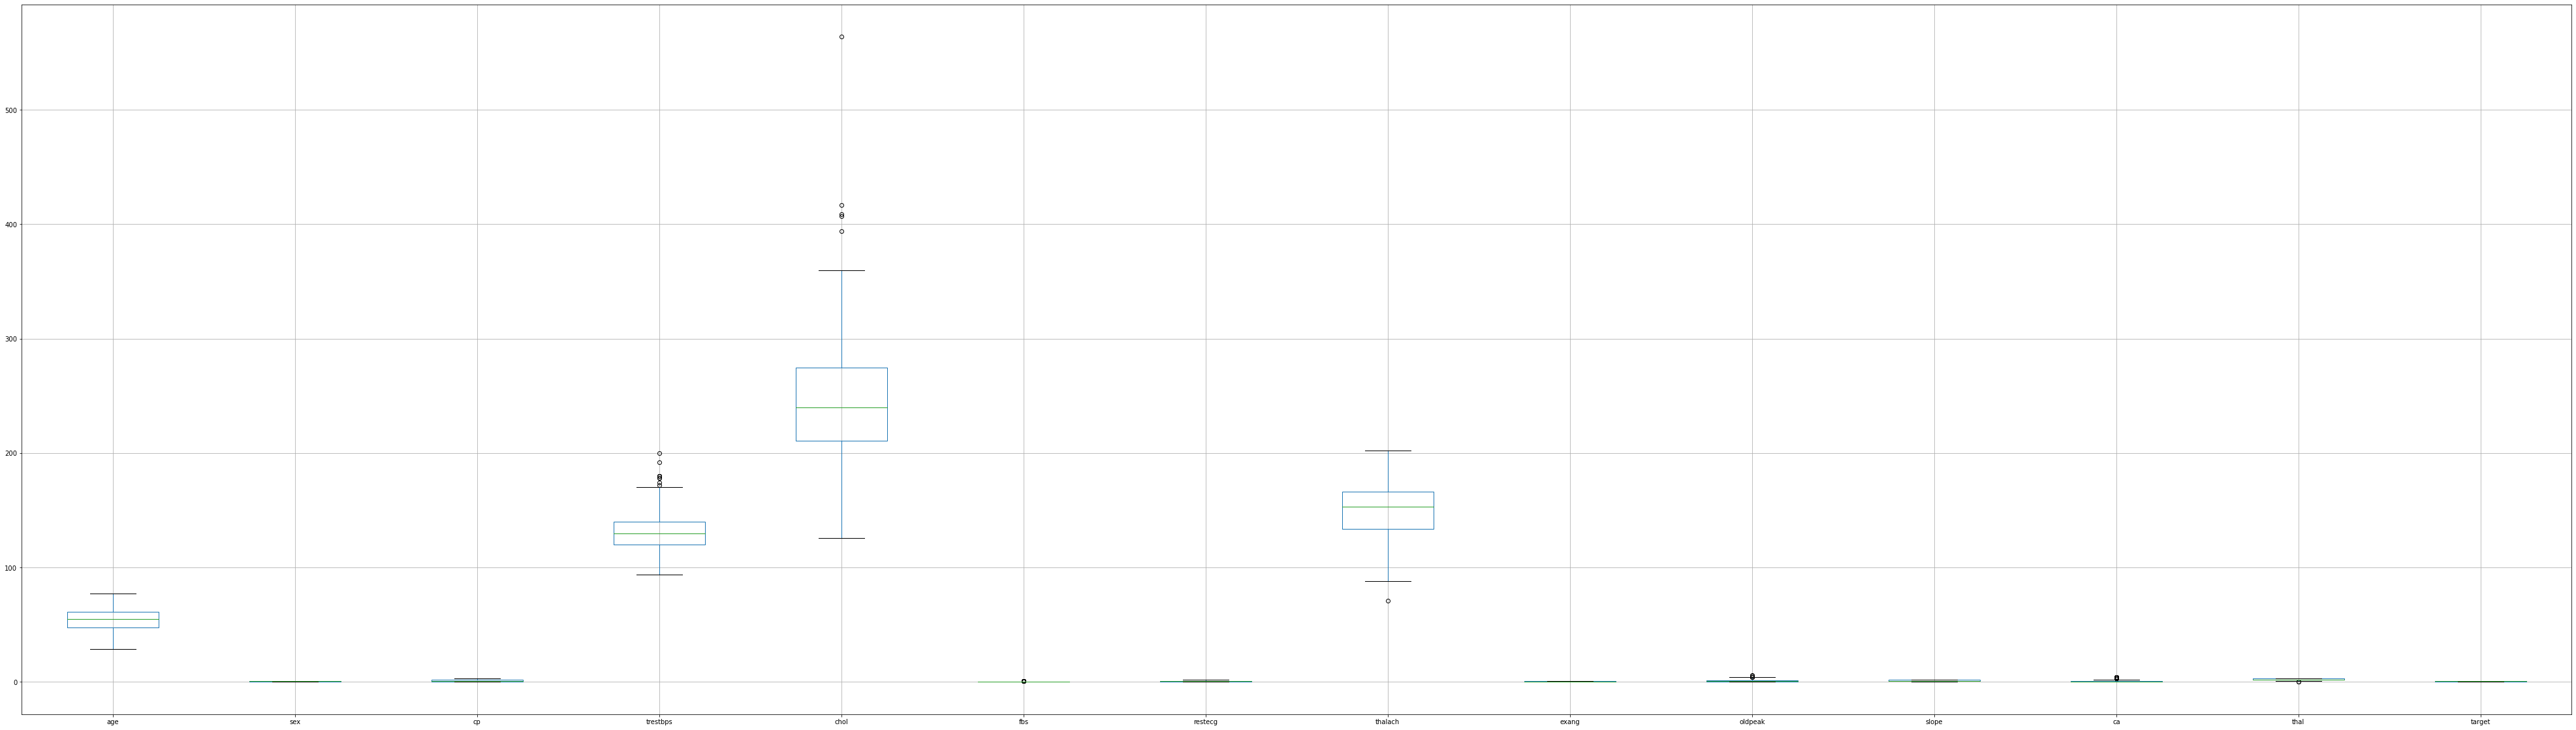

In [4]:
heart.boxplot(list(heart.columns),figsize=(70,20));

In [5]:
def preprocess(data,target,verbose=True):
    assert isinstance(data,pd.DataFrame), "Passed in data must be a Pandas DataFrame"
    
    # Drop nan values and duplicates
    no_na = data.dropna()
    no_dup = no_na.drop_duplicates()

    remove_indices = []
    for col in no_dup.drop(columns=target).columns:
        # Calculate z scores
        z = np.abs(stats.zscore(no_dup[col]))
        # Populate list with z scores above 3
        above_3_z = np.where(z > 3)
        remove_indices += list(above_3_z[0])

    remove_indices = np.unique(np.array(remove_indices))
    # Remove the outliers
    trimmed = no_dup.drop(remove_indices)

    
    if verbose:
        print(f"Dropped {len(data) - len(no_na)} row{'s' if (len(data) - len(no_na)) != 1 else ''} with missing value{'s' if (len(data) - len(no_na)) != 1 else ''}")
        print(f"Dropped {len(no_na) - len(no_dup)} duplicate row{'s' if (len(no_na) - len(no_dup)) != 1 else ''}")
        print(f"Dropped {len(remove_indices)} outlier{'s' if len(remove_indices) != 1 else ''}")
    
    return trimmed

In [6]:
new_heart = preprocess(heart,"target")

Dropped 0 rows with missing values
Dropped 1 duplicate row
Dropped 15 outliers


In [7]:
def conv_col_to_ohe(data,col):
    # DataFrame of OHE column
    d = pd.get_dummies(data[col])
    # Reset the column names to something that makes more sense
    d.columns = [f"{col}{i}" for i in d.columns]
    # Return a combined version of the original DataFrame
    # But with original column removed and new columns added
    return pd.concat([data.drop(col,axis=1), d],axis=1)

In [8]:
# OHE every categorical column
new_heart = conv_col_to_ohe(new_heart,"cp")
new_heart = conv_col_to_ohe(new_heart,"fbs")
new_heart = conv_col_to_ohe(new_heart,"restecg")
new_heart = conv_col_to_ohe(new_heart,"exang")
new_heart

,age,sex,trestbps,chol,thalach,oldpeak,slope,ca,thal,target,...,cp1,cp2,cp3,fbs0,fbs1,restecg0,restecg1,restecg2,exang0,exang1
0,63,1,145,233,150,2.3,0,0,1,1,...,0,0,1,0,1,1,0,0,1,0
1,37,1,130,250,187,3.5,0,0,2,1,...,0,1,0,1,0,0,1,0,1,0
2,41,0,130,204,172,1.4,2,0,2,1,...,1,0,0,1,0,1,0,0,1,0
3,56,1,120,236,178,0.8,2,0,2,1,...,1,0,0,1,0,0,1,0,1,0
4,57,0,120,354,163,0.6,2,0,2,1,...,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,140,241,123,0.2,1,0,3,0,...,0,0,0,1,0,0,1,0,0,1
299,45,1,110,264,132,1.2,1,0,3,0,...,0,0,1,1,0,0,1,0,1,0
300,68,1,144,193,141,3.4,1,2,3,0,...,0,0,0,0,1,0,1,0,1,0
301,57,1,130,131,115,1.2,1,1,3,0,...,0,0,0,1,0,0,1,0,0,1


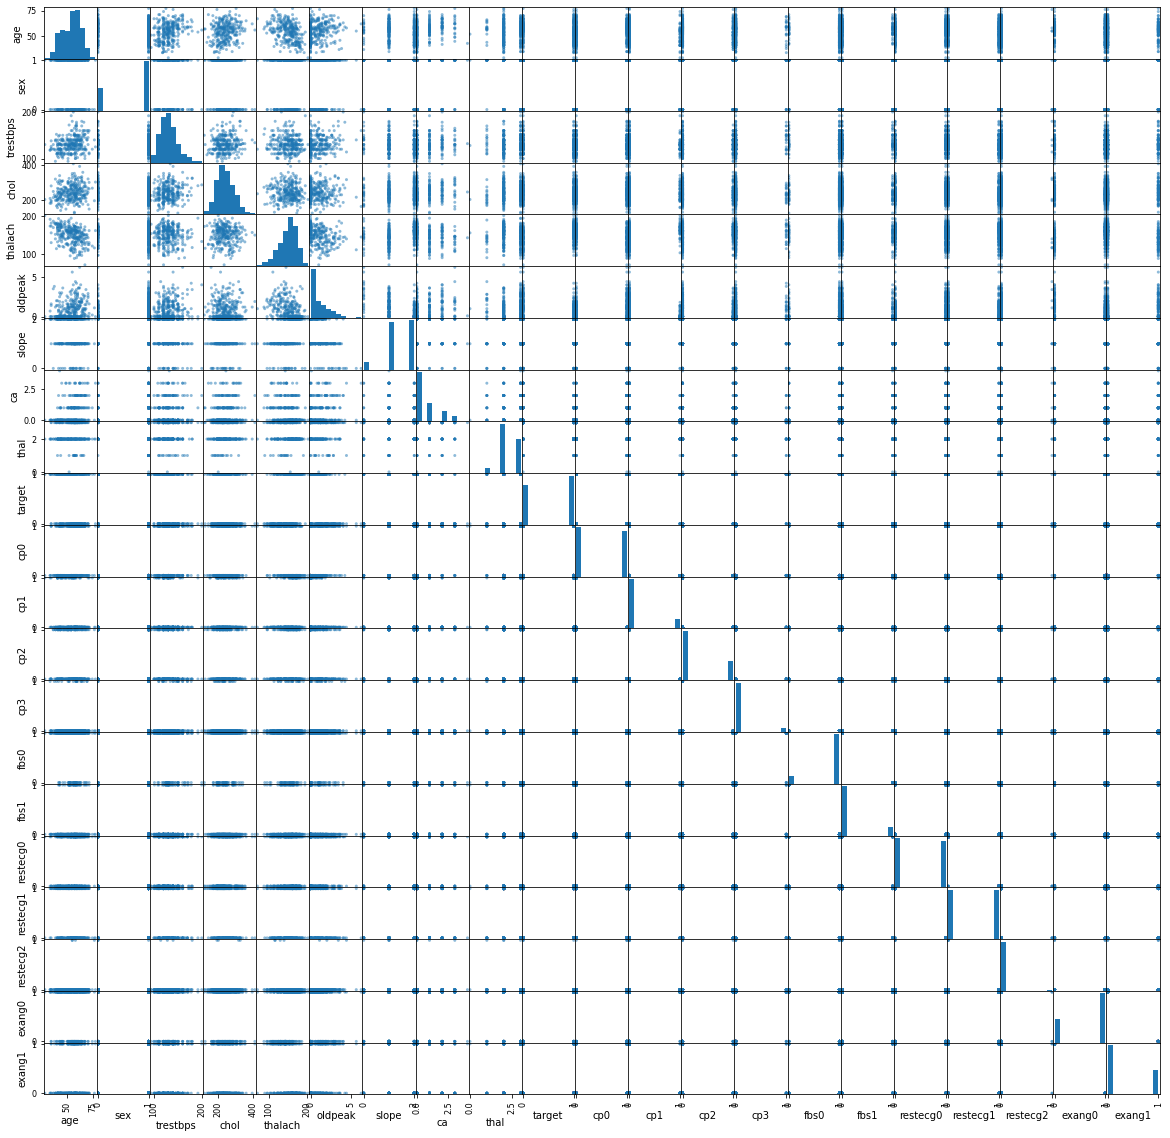

In [9]:
# Use built in SPLOM method to plot
pd.plotting.scatter_matrix(new_heart,figsize=(20,20))
plt.show()

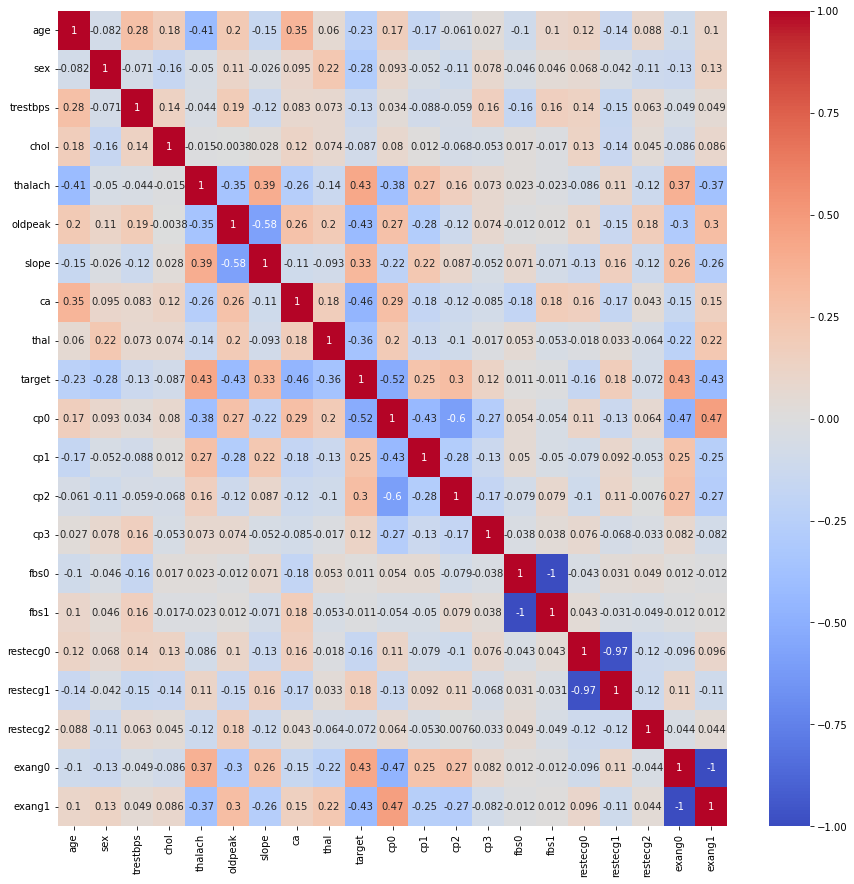

In [10]:
fig = plt.figure(figsize=(15,15))
# Get the correlation matrix
corr = new_heart.corr()
# Plot the heatmap
sns.heatmap(corr,annot=True,cmap=sns.color_palette("coolwarm", as_cmap=True))
plt.show()

In [11]:
# Split the training data into 80/20 train/test
heart_train, heart_test = train_test_split(new_heart,test_size=.2)

# Drop the target column
heart_train_x = heart_train.drop("target",axis=1)
# Scale the x data with a Standard Scaler
scaler = StandardScaler()
heart_train_x = pd.DataFrame(scaler.fit_transform(heart_train_x), columns=heart_train_x.columns)
# Y data is the target
heart_train_y = heart_train["target"]

# Same as above, but for the testing data
heart_test_x = heart_test.drop("target",axis=1)
scaler = StandardScaler()
heart_test_x = pd.DataFrame(scaler.fit_transform(heart_test_x), columns=heart_test_x.columns)
heart_test_y = heart_test["target"]

In [12]:
def run_diff_kernel(kernel):
    if kernel == "linear":
        param_grid = {"C": [1e-1,1,1e2,1e3, 1e4, 1e5],}
        clf = GridSearchCV(LinearSVC(max_iter=2000), param_grid,n_jobs=-1)
    else:
        # Build a parameter grid to run certain models with
        param_grid = {"C": [1e-1,1,1e2,1e3, 1e4, 1e5],"gamma": [0.0001, 0.001, 0.01, 0.1],}
        # Create the grid and pass in the parameters
        clf = GridSearchCV(SVC(kernel=kernel, class_weight="balanced",cache_size=1000), param_grid,n_jobs=-1)
    
    clf.fit(heart_train_x,heart_train_y)

    # Predict
    heart_test_pred = clf.predict(heart_test_x)
    
    # Show what is the best estimator and the detailed prediction report
    print(f"Kernel: {kernel}")
    print(clf.best_estimator_)
    print(classification_report(heart_test_y,heart_test_pred))
    
    y_score = clf.best_estimator_.decision_function(heart_test_x)
    
    # Calculate the ROC Curve
    fpr, tpr, _ = roc_curve(heart_test_y,y_score)
    roc_auc = auc(fpr,tpr)

    # Plot the roc curve
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label=f"ROC curve (area = {roc_auc:0.2f})",
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()
    
    # Plot the confusion matrix from the first model
    cm = confusion_matrix(heart_test_y,heart_test_pred,labels=clf.best_estimator_.classes_)
    disp = ConfusionMatrixDisplay(cm,display_labels=clf.best_estimator_.classes_)
    disp.plot()
    plt.title(f"Confusion Matrix for {kernel} kernel")
    plt.show()
    print()

Kernel: rbf
SVC(C=1, cache_size=1000, class_weight='balanced', gamma=0.001)
              precision    recall  f1-score   support

           0       0.90      0.69      0.78        26
           1       0.79      0.94      0.86        32

    accuracy                           0.83        58
   macro avg       0.84      0.81      0.82        58
weighted avg       0.84      0.83      0.82        58



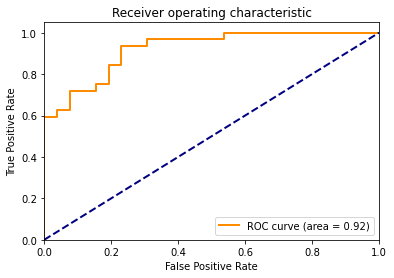

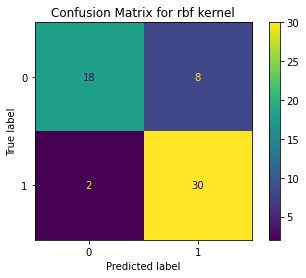


Kernel: poly
SVC(C=1, cache_size=1000, class_weight='balanced', gamma=0.1, kernel='poly')
              precision    recall  f1-score   support

           0       0.92      0.85      0.88        26
           1       0.88      0.94      0.91        32

    accuracy                           0.90        58
   macro avg       0.90      0.89      0.89        58
weighted avg       0.90      0.90      0.90        58



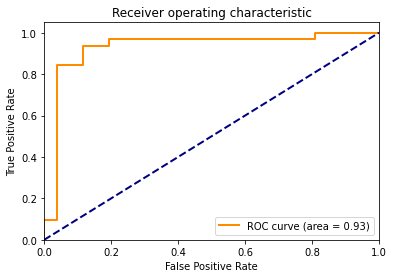

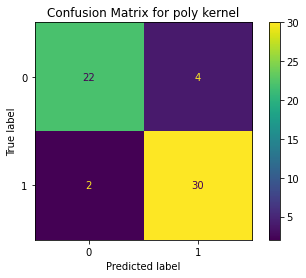


Kernel: linear
LinearSVC(C=1, max_iter=2000)
              precision    recall  f1-score   support

           0       0.96      0.85      0.90        26
           1       0.89      0.97      0.93        32

    accuracy                           0.91        58
   macro avg       0.92      0.91      0.91        58
weighted avg       0.92      0.91      0.91        58



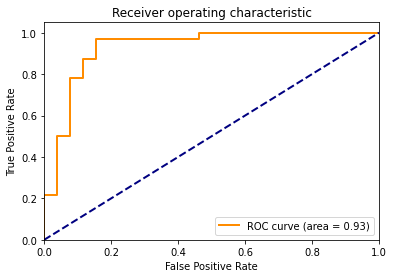

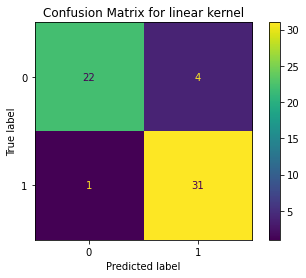

In [13]:
for kernel in ["rbf","poly","linear"]:
    run_diff_kernel(kernel)

# Discussion of SVM methods
### RBF Kernel
- Performed definitely the fastest
- Performed fairly well with an accuracy of about 81%
- The ROC curve and the confusion matrix show that there was a lot of times it was supposed to predict 1 and it predicted 0 (more than any other kernel)
- ROC area of .91 which isn't bad, but definitely less than the other kernels
### Polynomial Kernel
- Sigfnificantly higher accuracy than the rbf kernel, and roughly the same accuracy as the linear kernel
- Was capable of correctly classifying one more data point than the linear kernel, and had less problems with trying to classify something as a 1 when it was actually a 0
- ROC area of .94 which is very good, means robust to False Positives
### Linear Kernel
- Instead of using the SVC implementation that used libsvm, had to use the LinearSVC which uses liblinear. However, the time complexity of liblinear is much lower than libsvm
- Gamma parameter cannot be tuned
- Very good accuracy of 86%
- Slighlty higher ROC area than the RBF kernel, but less than the polynomial
- Similar confusion matrix to the polynomial kernel, only incorrectly identifying one point as class 0 when it should have been 1


# New section dealing with Agglomerative clustering

In [14]:
# Taken from and scikit-learn demo
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [15]:
customers = pd.read_excel("./Customers.xlsx")
customers

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,1,1,19,15,39,3
1,2,1,21,15,81,4
2,3,0,20,16,6,3
3,4,0,23,16,77,4
4,5,0,31,17,40,3
...,...,...,...,...,...,...
195,196,0,35,120,79,1
196,197,0,45,126,28,0
197,198,1,32,126,74,1
198,199,1,32,137,18,0


In [16]:
# Remove unnecessary data
customers = customers.drop("CustomerID",axis=1)

In [17]:
# Preprocess
cust_proc = preprocess(customers,"cluster")

Dropped 0 rows with missing values
Dropped 0 duplicate rows
Dropped 0 outliers


In [18]:
# Setup x and y training data
x_data = cust_proc.drop("cluster",axis=1)
y_data = cust_proc["cluster"]

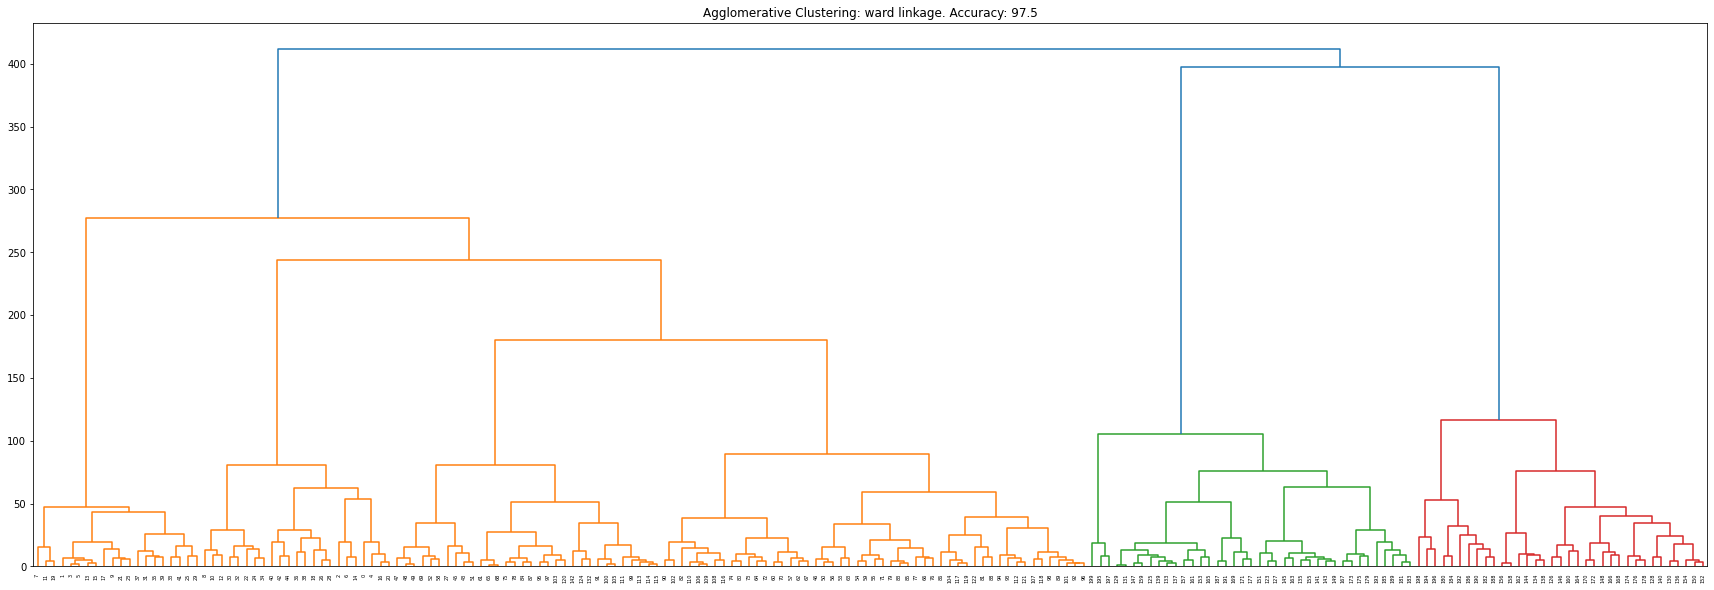

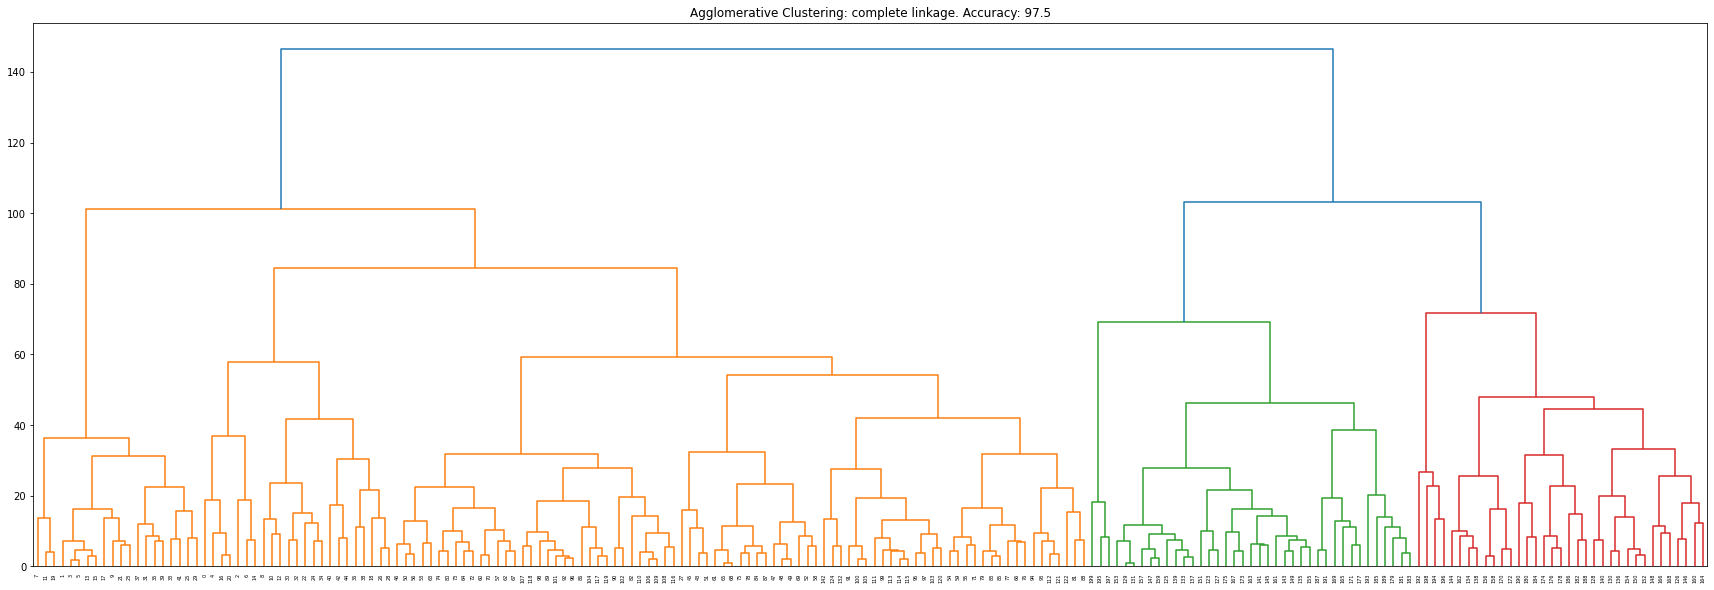

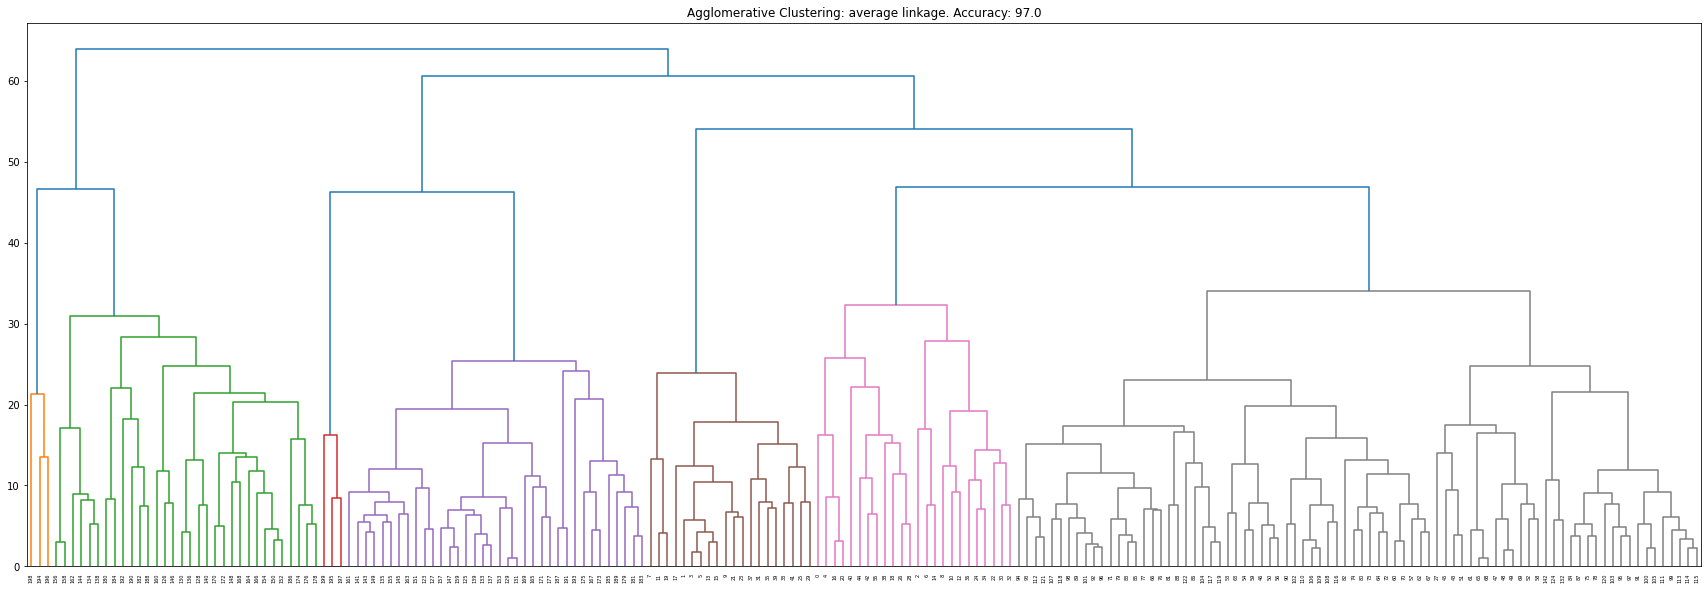

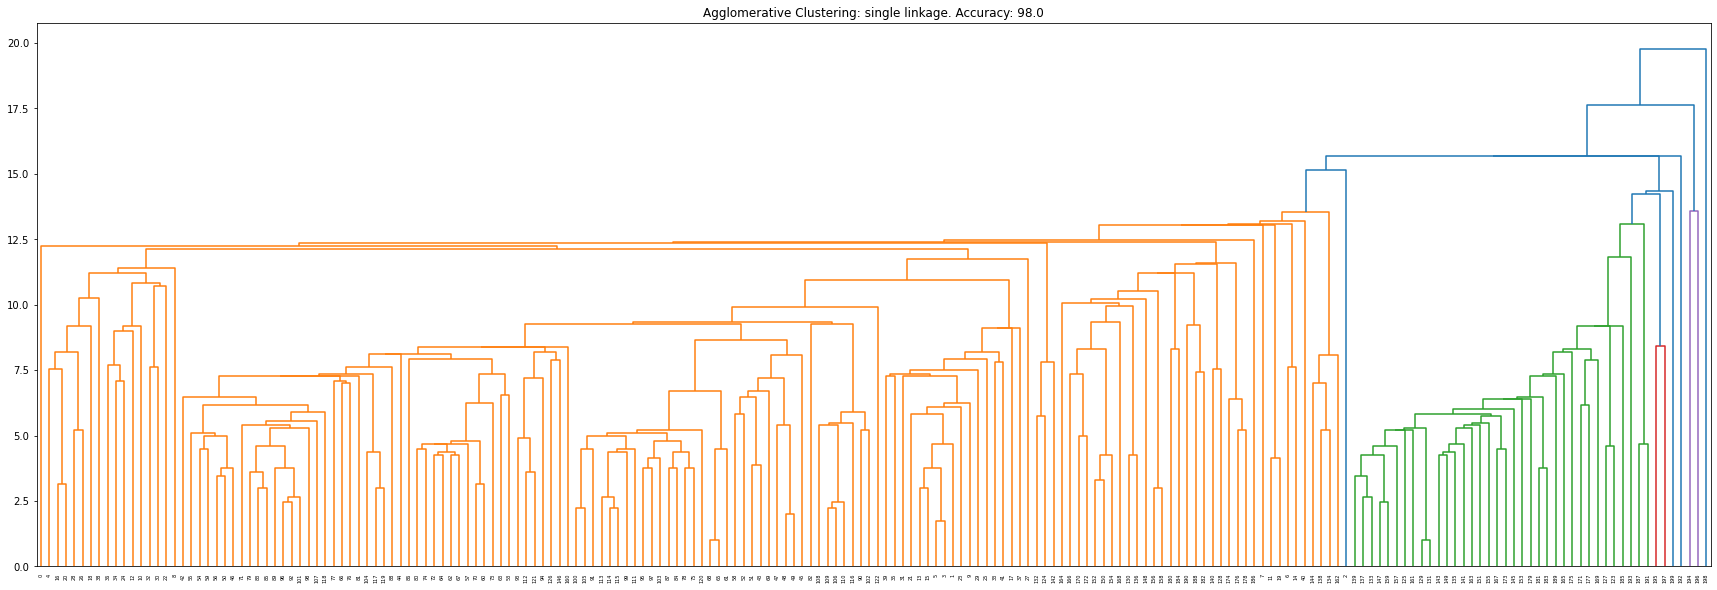

In [19]:
# Iterate over all models of linkage
for mode in ["ward", "complete", "average", "single"]:
    # Creates a model with the spefici linkage type
    # We set the n_clusters method since we believe there are 5 clusters (we know this from before)
    # If we did not know this, we could set the distance threshold and then compare the clusters but we wouldn't be able to plot the dendrogram with the function I use
    model = AgglomerativeClustering(linkage=mode,distance_threshold=None,n_clusters=5)
    
    # Fit and predict, add it as a column
    pred = model.fit_predict(x_data)
    customers["prediction"] = pred

    # This caclulates the accuracy of the model
    n_correct = 0
    # Iterate over every value in the cluster column (actual cluster it belongs to)
    for val in customers["cluster"].unique():
        # Build a dictionary that we can use for "remapping"
        # Instead of remapping, we'll just find the label for the value that it defines this cluster as since the clusters will most likely not line up
        num = {}
        for row in customers[customers['cluster'] == val].itertuples():
            try:
                num[row.prediction] += 1
            except:
                num[row.prediction] = 1
        # This is number of values in the predicted clusters with the highest count
        # Basically, we find the cluster that it predicts the label for, and count all of those labels
        # If they all match, then it correctly identified this cluster
        # If it doesn't then the accuracy is decreased
        n_correct += num[max(num, key=num.get)]
        
    model = AgglomerativeClustering(linkage=mode,distance_threshold=0,n_clusters=None)
    model.fit(x_data)
    fig = plt.figure(figsize=(30,10))
    plt.title(f"Agglomerative Clustering: {mode} linkage. Accuracy: {n_correct / len(customers) * 100}")
    plot_dendrogram(model,truncate_mode=None)
    plt.show()

# Comparison of methods
### Ward
The Ward Linkage method is very similar to Analysis of Variance (ANOVA) by combining two clusters by increases the error sum of squares (ESS). It is also the only top-down linkage method used in this assignment
- The dendrogram shows that the distance to form 5 clusters is around 200
    - Using this at the bottom, we can see this directly in the plots at the bottom when we draw the line and use the distance threshold to compute clusters
- It seems that the clusters themselves form fairly evenly, almost splitting the space in half each time
- It obtains an accuracy of 97.5% which is pretty good

### Complete
The Complete Linkage method is somewhat similar to the Ward method, but instead of increasing the ESS to combine a cluster, it uses the furthest points from each cluster to each other cluster, and combines the closest pair. This method is bottom-up
- The dendrogram shows that the distances to form 5 clusters is around 75
    - Using this at the bottom, we can see this directly in theplots at the obttom when we draw the line and use the distance threshold to compute clusters
- Similar to the Ward method, the clusters seem to form some what uniformly, and the overall dendrogram looks similar to that of the Ward method
- It obatins an accuracy of 97.5% as well, which is still pretty good

### Average
The Average Linkage method is somewhat similar to the Ward and Complete method, but instead of increasing ESS or using the furthest points, it computes the average of each cluster, and finds the closest averages to combine. This method is bottom-up
- The dendrogram looks very different from both the Ward and the Complete dendrogram
- The distances between each combination seems to be more condensed, meaning that within a certain distance window it seems to create more clusters than the other methods
- The dendrogram shows that the distance to form 5 clusters is around 46.7
    - Using this at the bottom, we can see this directly in theplots at the obttom when we draw the line and use the distance threshold to compute clusters
- The Average method performs slightly worse than the other clustering methods with an accuracy of 97%, but that is still pretty good comparatively

### Single
The Single method is somewhat similar to the Complete method, but instead of finding the furthest points, it finds the closest points in the cluster and then uses those to combine. This method is bottom-up
- This dendrogram looks very different from the other linking methods. It looks more noisy, but it seems easier to find the sections where it makes large combinations of clusters
- The clusters are definitely less uniformly created, as the bottom section of the dendrogram is more noisy and the heights seem much less uniform
- The dendrogram shows that the distance to form 5 clusters is around 15.5
    - Using this at the bottom, we can see this directly in theplots at the obttom when we draw the line and use the distance threshold to compute clusters
- The Sinlge method performs the best out of all the methods with an accuracy of 98%, but it's not a large increase in accuracy from the other methods

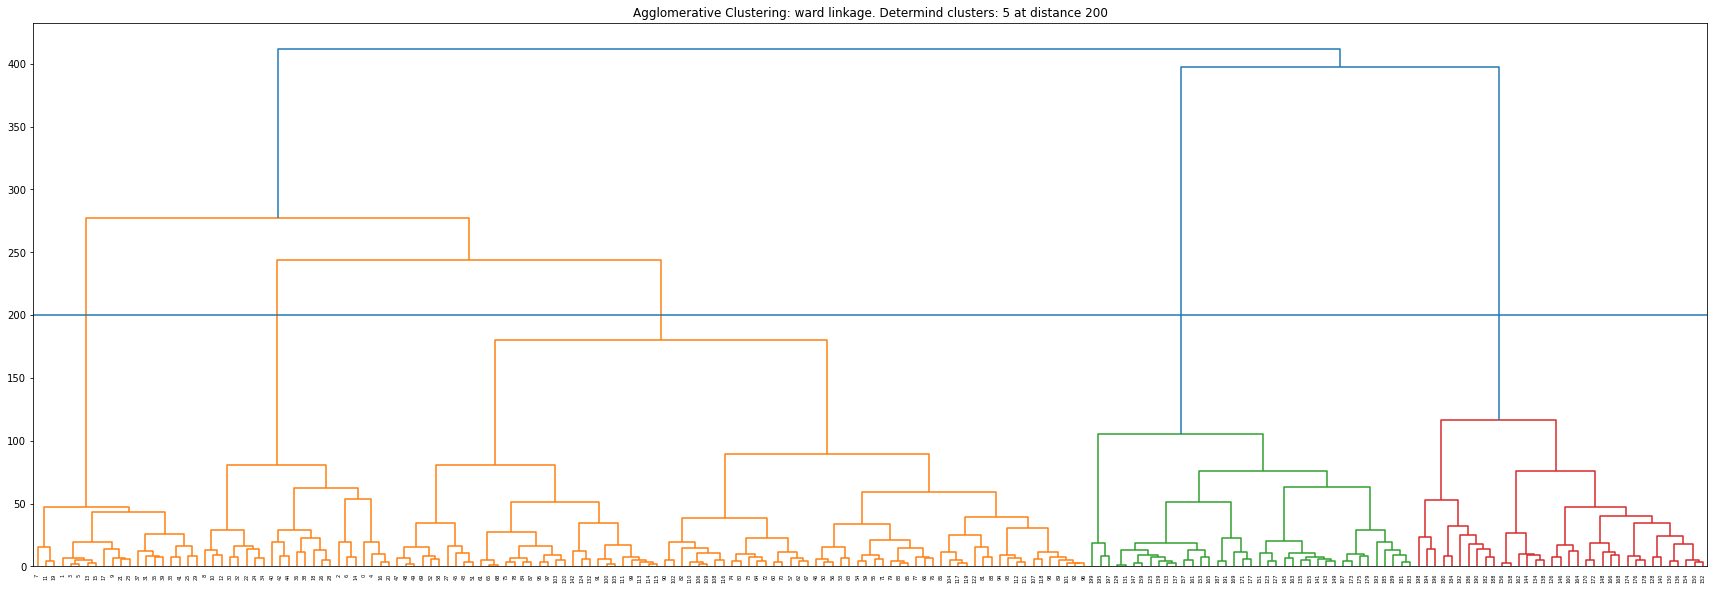

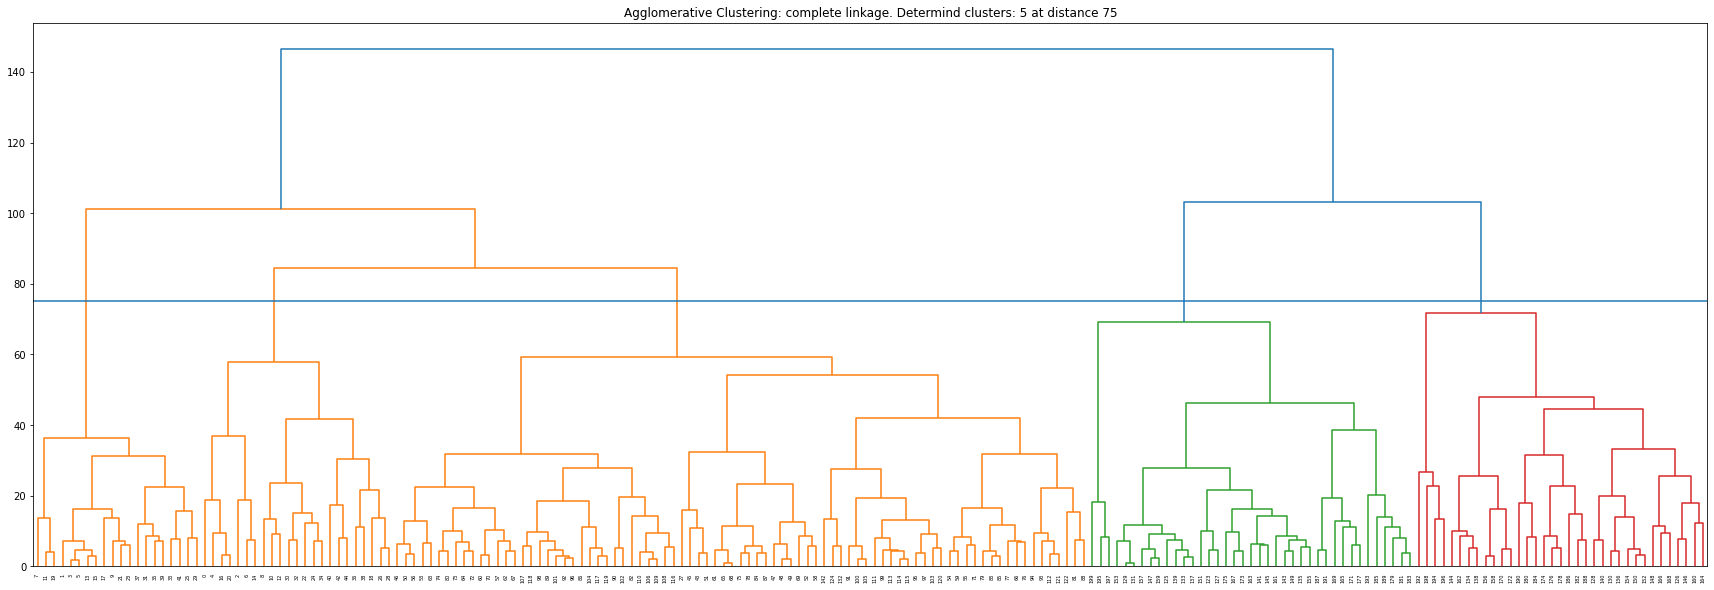

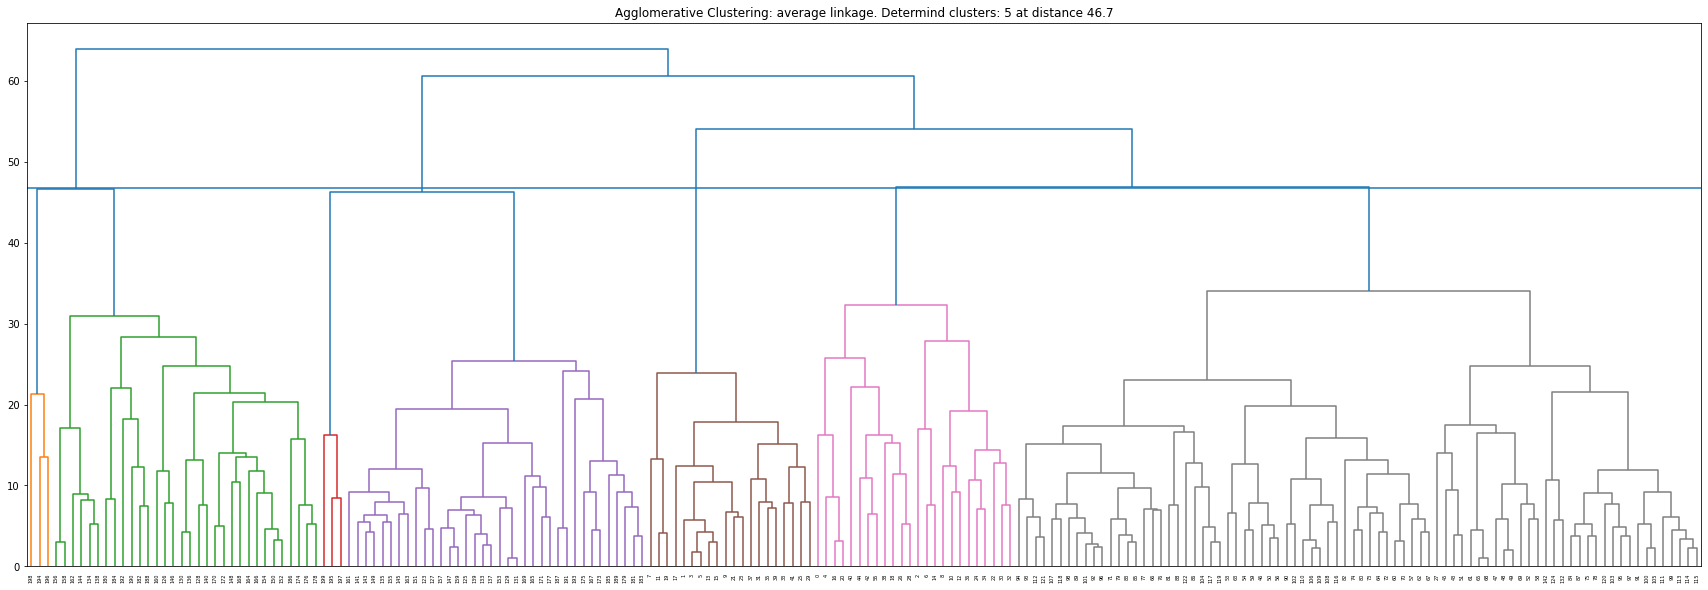

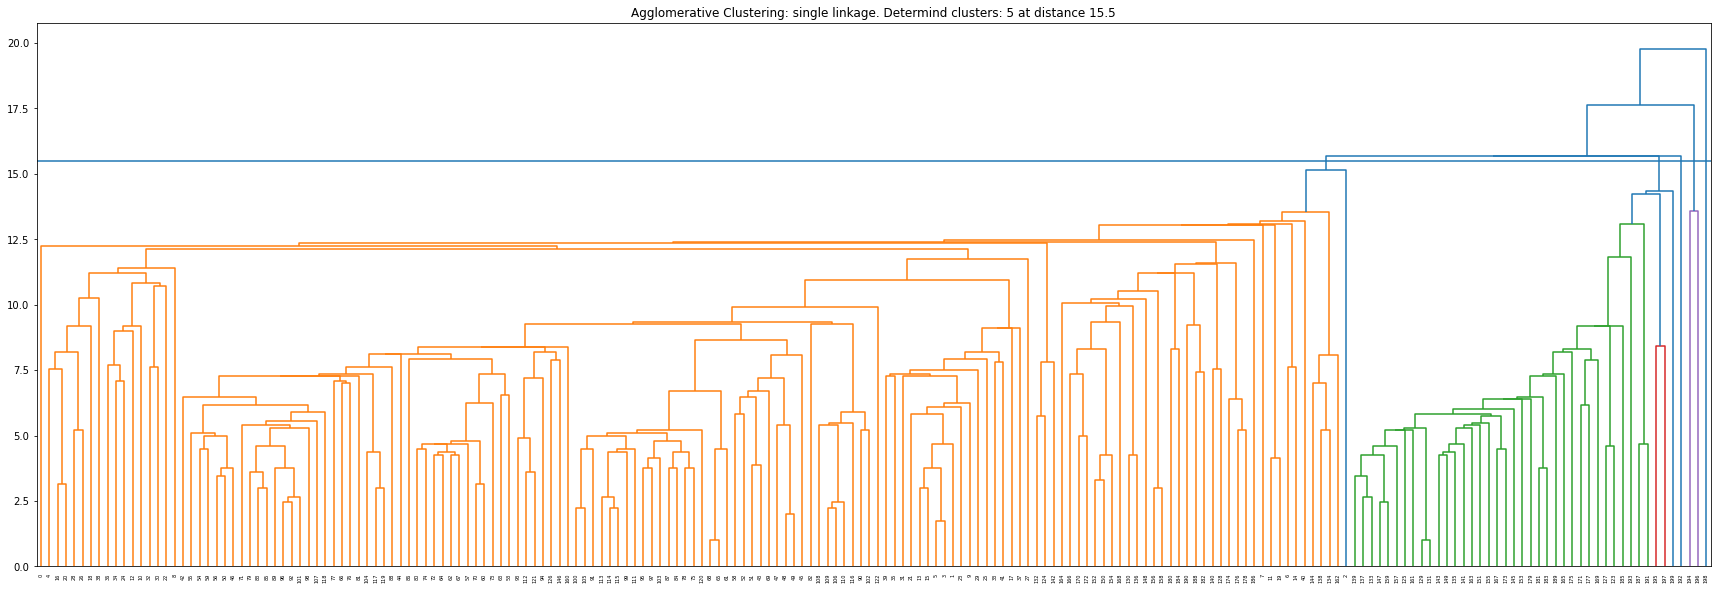

In [20]:
# This whole section shows that using the specific density threshold we find the 5 clusters
# And if we draw the horizontal line at that height, it is true
for linkage, distance in zip(["ward","complete","average","single"], [200,75,46.7,15.5]):
    model = AgglomerativeClustering(linkage=linkage,distance_threshold=distance,n_clusters=None,compute_distances=True)
    model.fit(x_data)
    determined = model.n_clusters_
    model = AgglomerativeClustering(linkage=linkage,distance_threshold=0,n_clusters=None)
    model.fit(x_data)
    fig = plt.figure(figsize=(30,10))
    plt.title(f"Agglomerative Clustering: {linkage} linkage. Determind clusters: {determined} at distance {distance}")
    plot_dendrogram(model,truncate_mode=None)
    plt.axhline(y=distance)
    plt.show()

# Conclusion
In this assignment, we looked at SVM and Agglomerative Clustering and compared the different methods between them.
For the most part, the metric we used was Accuracy since it is the simplest to obtain, but in cases where the labels matched 1:1 (not the case for clustering), we can also compute Precision and Recall.
Depending on what the desired result is, we may want to increase accuracy (general approach to model building), or pick a specific example like minimizing false negatives (in the medical field).
Most models tested performed fairly well in the tasks, with some advantages over others. In the case of SVM there were definitely some more clear advantages to specific kernels than others.
For example, computation time vs accuracy was a trade off. The more accurate kernels took longer and usually had to be manually tuned instead of using "brute force" grid searching.
However, when it came to Agglomerative Clustering, the time for each algorithm is roughly the same, since the time complexity of each algorithm is roughly the same. Therefore, it mostly depends on what method you would like to use to form clusters,
and if it makes more sense to do top-down or bottom-up approaches.